In [1]:
!pip install opencv-python

In [2]:
!pip install pillow

In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install torchvision

In [5]:
pip install facenet-pytorch

  Obtaining dependency information for facenet-pytorch from https://files.pythonhosted.org/packages/ed/2e/2d56386bc2f834cdc683743903852cf1428b4e5ee119f16cf808b589d3cd/facenet_pytorch-2.6.0-py3-none-any.whl.metadata
  Using cached facenet_pytorch-2.6.0-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for torch<2.3.0,>=2.2.0 from https://files.pythonhosted.org/packages/5c/01/5ab75f138bf32d7a69df61e4997e24eccad87cc009f5fb7e2a31af8a4036/torch-2.2.2-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.2.2-cp311-cp311-win_amd64.whl.metadata (26 kB)
  Obtaining dependency information for torchvision<0.18.0,>=0.17.0 from https://files.pythonhosted.org/packages/c6/75/d869f600fc33df8b8ca99943e165a4ca23b73c68dc1942098fde0a6b46f3/torchvision-0.17.2-cp311-cp311-win_amd64.whl.metadata
  Using cached torchvision-0.17.2-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
Using cached facenet_pytorch-2.6.0-py3-none-any.whl (1.9 MB)
Using cached torch-2.2.2-cp311-cp311-win_amd64.whl (19

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import torch
import cv2
import numpy as np
from facenet_pytorch import InceptionResnetV1
from matplotlib import pyplot as plt

In [4]:
def load_facenet_model():
    model = InceptionResnetV1(pretrained='vggface2').eval()
    return model

In [5]:
def preprocess_image(image):
    image_resized = cv2.resize(image, (160, 160))  # Taille attendue par FaceNet
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_normalized = (image_rgb - 127.5) / 128.0  # Normalisation
    image_tensor = torch.tensor(image_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    return image_tensor

In [6]:
def extract_features(image, facenet_model):
    image_tensor = preprocess_image(image)
    with torch.no_grad():  # Désactiver le calcul des gradients
        embeddings = facenet_model(image_tensor)  # Extraire les caractéristiques
    return embeddings

In [7]:
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [8]:
def detect_faces_opencv(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

In [9]:
def detect_eyes_opencv(face_region):
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray_face, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))
    return eyes

In [10]:
def align_face(image, left_eye, right_eye):
    # Calculer le centre des yeux
    left_eye_center = (int(left_eye[0] + left_eye[2] / 2), int(left_eye[1] + left_eye[3] / 2))
    right_eye_center = (int(right_eye[0] + right_eye[2] / 2), int(right_eye[1] + right_eye[3] / 2))

    # Calculer l'angle de rotation
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dy, dx))  # Calculer l'angle entre les deux yeux

    # Calculer le centre du visage
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                   (left_eye_center[1] + right_eye_center[1]) // 2)

    # Créer la matrice de rotation pour aligner le visage
    rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, scale=1)

    # Appliquer la transformation pour aligner le visage
    aligned_face = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    return aligned_face

In [11]:
def draw_rectangle(image, x, y, w, h):
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [12]:
def draw_eyes(image, eyes, offset_x=0, offset_y=0):
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(image, (ex + offset_x, ey + offset_y), (ex + ew + offset_x, ey + eh + offset_y), (255, 0, 0), 2)

In [13]:
def process_face_extraction_opencv(image_path):
    # Charger l'image
    image = cv2.imread(image_path)

    # Vérifier si l'image est bien chargée
    if image is None:
        print("Erreur: L'image n'a pas pu être chargée. Vérifiez le chemin du fichier.")
        return

    # Afficher l'image originale
    display_image(image)

    # Charger le modèle FaceNet
    facenet_model = load_facenet_model()

    # Détecter les visages dans l'image avec OpenCV
    faces = detect_faces_opencv(image)
    if len(faces) == 0:
        print("Aucun visage détecté.")
        return

    print(f"Visages détectés : {len(faces)}")

    # Extraire les caractéristiques de chaque visage détecté
    for (x, y, w, h) in faces:
        # Dessiner un rectangle autour du visage
        draw_rectangle(image, x, y, w, h)

        # Extraire la région du visage
        face_region = image[y:y+h, x:x+w]

        # Détecter les yeux dans la région du visage avec OpenCV
        eyes = detect_eyes_opencv(face_region)

        # Vérifier que deux yeux ont été détectés
        if len(eyes) >= 2:
            left_eye, right_eye = eyes[:2]

            # Dessiner les rectangles autour des yeux pour vérifier la détection
            draw_eyes(face_region, eyes)
            display_image(face_region)  # Affiche le visage avec les rectangles des yeux

            # Aligner le visage en fonction des yeux
            aligned_face = align_face(face_region, left_eye, right_eye)

            # Extraire les caractéristiques du visage aligné
            embeddings = extract_features(aligned_face, facenet_model)

            print(f"Embeddings extraits pour un visage aligné : {embeddings}")
            print(f"Taille des embeddings : {embeddings.shape}")

            # Afficher le visage aligné
            display_image(aligned_face)
        else:
            print("Les yeux n'ont pas été correctement détectés pour aligner le visage.")
    
    # Afficher l'image avec les visages détectés
    display_image(image)

In [14]:
image="C:/Users/mahen/Intranet/Modele_IA/images/profil_picture/selena_profile_picture.jpg"

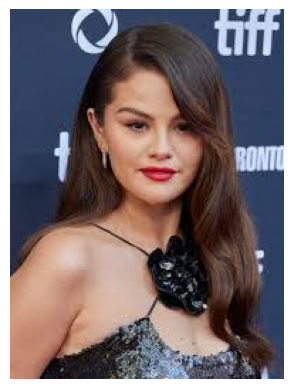

  0%|          | 0.00/107M [00:00<?, ?B/s]

Visages détectés : 1
Les yeux n'ont pas été correctement détectés pour aligner le visage.


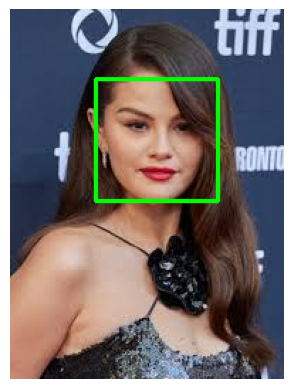

In [15]:
process_face_extraction_opencv(image)

In [16]:
image2="C:/Users/mahen/Intranet/Modele_IA/images/profil_picture/selena_profile_picture2.jpg"

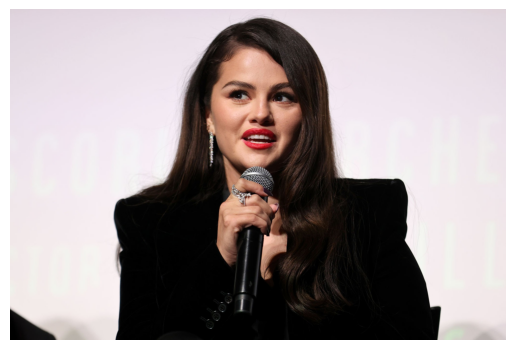

Visages détectés : 1


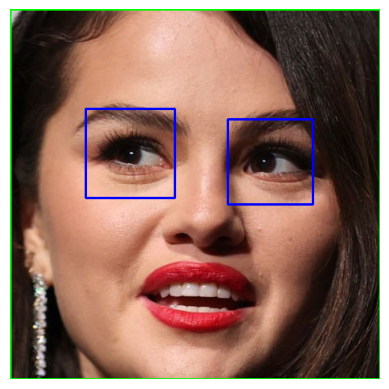

Embeddings extraits pour un visage aligné : tensor([[ 0.0787,  0.0474, -0.0437, -0.0038, -0.0600, -0.0652, -0.0236,  0.0726,
          0.0738, -0.0234,  0.0526, -0.0510, -0.0049, -0.0667, -0.0202, -0.0007,
          0.0868,  0.0332,  0.0066, -0.0260, -0.0091, -0.0732,  0.0352, -0.0347,
         -0.0126, -0.0365, -0.0339, -0.0107, -0.0039,  0.0250, -0.0466, -0.0529,
         -0.0636,  0.0075,  0.0358,  0.0491,  0.0238, -0.0238, -0.0256,  0.0319,
          0.0111, -0.0406, -0.0043,  0.0451, -0.0254,  0.0166,  0.0084,  0.0809,
         -0.0020, -0.0274,  0.0493,  0.0064, -0.0022,  0.0664,  0.0607,  0.0232,
         -0.0101,  0.0018, -0.0119,  0.0151, -0.0546, -0.0096, -0.0640,  0.0307,
         -0.0030, -0.0542,  0.0791,  0.0733,  0.0881, -0.0753,  0.0377, -0.0199,
         -0.0554, -0.0786, -0.0032, -0.1362, -0.0336, -0.0076,  0.0120,  0.0407,
         -0.0623,  0.0083,  0.0248,  0.0305, -0.1277,  0.1014, -0.0039, -0.0281,
          0.0911,  0.0382, -0.0513,  0.0441, -0.0864, -0.0304, -0

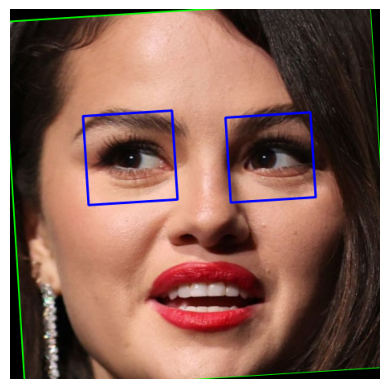

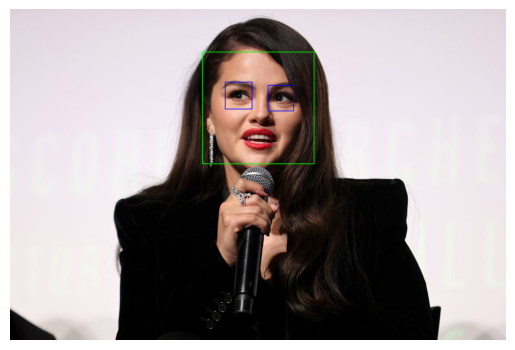

In [17]:
process_face_extraction_opencv(image2)

In [18]:
images = "C:/Users/mahen/Intranet/Modele_IA/images/picture/selena_picture_1.jpg"

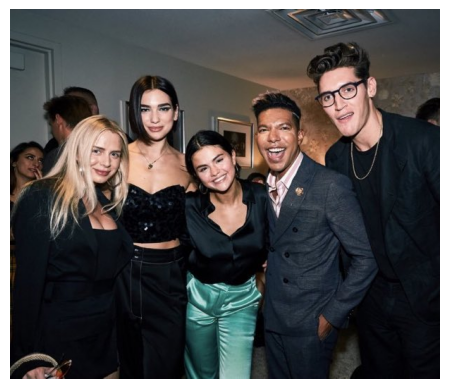

Visages détectés : 5
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.
Les yeux n'ont pas été correctement détectés pour aligner le visage.


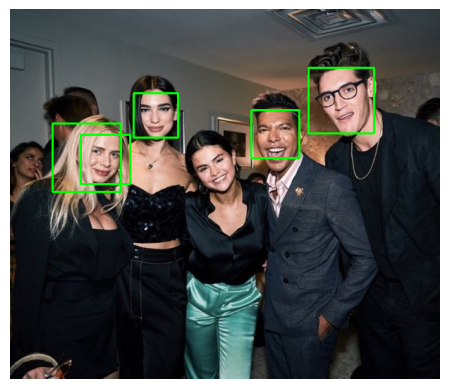

In [19]:
process_face_extraction_opencv(images)

In [22]:
images2 = "C:/Users/mahen/Intranet/Modele_IA/images/picture/selena_picture_2.jpg"

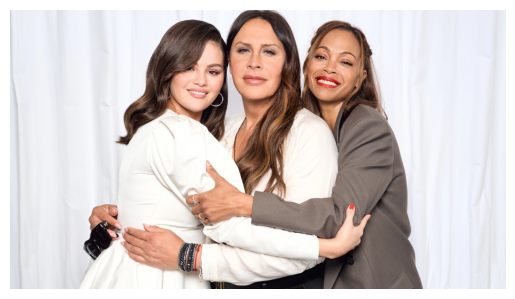

Visages détectés : 3


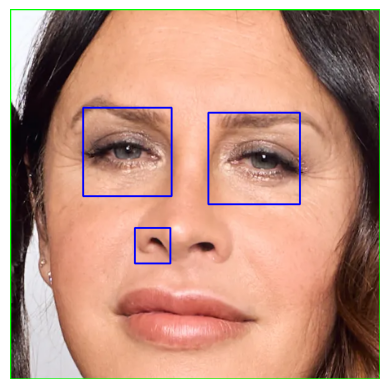

Embeddings extraits pour un visage aligné : tensor([[ 1.5019e-02,  8.1641e-02, -2.0590e-02, -6.0818e-02, -4.6106e-02,
          2.9226e-02,  2.0255e-02, -3.3646e-02,  3.8477e-02,  4.1185e-02,
         -6.7878e-02,  6.0343e-02, -2.7293e-02, -3.7639e-02,  5.6396e-03,
          2.6567e-02,  8.1291e-02,  1.5498e-02,  2.1411e-02,  3.3487e-03,
         -5.7925e-02, -4.1830e-03, -1.5339e-02,  6.0721e-04,  3.2108e-02,
         -3.4302e-02, -5.2853e-02,  4.7796e-03, -4.8304e-02,  2.7690e-02,
          1.5584e-02,  1.1564e-03, -1.8155e-03,  5.2512e-02, -1.7645e-02,
         -1.6274e-02,  4.1584e-03, -1.5579e-02,  2.9861e-02,  6.5694e-02,
         -1.1968e-02, -3.1809e-02, -9.0710e-03,  5.4813e-02,  9.6261e-03,
          2.5540e-02,  2.8607e-02, -2.4237e-02,  4.0606e-02,  8.7281e-03,
          1.0873e-02,  1.5056e-02, -3.0765e-02, -2.3343e-02,  1.5517e-02,
          2.1714e-02, -2.4169e-03, -4.0294e-02, -2.9011e-02,  8.5056e-04,
         -4.2408e-02,  7.2601e-02, -2.3267e-03,  9.9127e-03, -3.7713

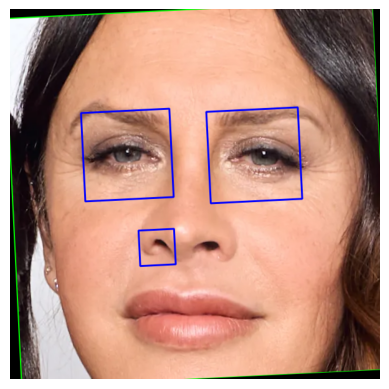

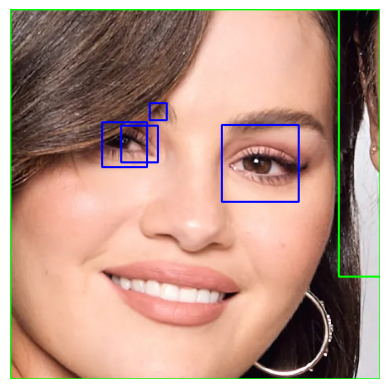

Embeddings extraits pour un visage aligné : tensor([[ 5.7798e-02,  6.9577e-02, -6.1055e-02, -9.5829e-05, -6.1007e-02,
         -3.1470e-02,  1.4482e-02,  5.7458e-02,  3.7337e-02, -2.2344e-02,
         -2.3692e-03, -3.6622e-02, -2.7803e-02, -2.3386e-02,  4.0672e-02,
         -6.6319e-02,  1.0756e-01,  6.3205e-02,  3.4485e-02,  1.2230e-02,
          2.3818e-02, -6.3532e-02,  7.5659e-03, -3.4449e-02,  3.4554e-02,
         -5.4316e-02,  9.7260e-03,  1.0832e-02,  4.7240e-02,  2.7454e-02,
         -2.1177e-02, -5.1607e-02, -6.9702e-02,  1.9353e-02, -2.8561e-02,
          4.5231e-02, -2.7303e-02,  3.1452e-03,  6.3187e-02,  4.7439e-02,
         -2.0495e-02, -5.8084e-02, -3.8242e-02,  2.4981e-02, -1.5377e-03,
          4.6721e-02, -1.3091e-02,  1.7050e-02,  2.7848e-02, -4.3462e-02,
          7.9982e-02, -8.4074e-03, -1.4971e-02,  9.0410e-02,  1.1348e-02,
         -3.5891e-02,  4.9164e-03,  3.7739e-02,  8.0211e-03, -1.3024e-02,
         -8.6983e-02, -6.4714e-03, -6.4930e-02, -1.6001e-02, -2.3251

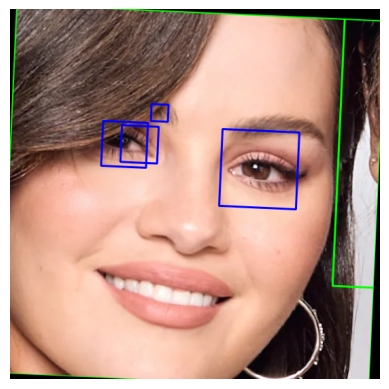

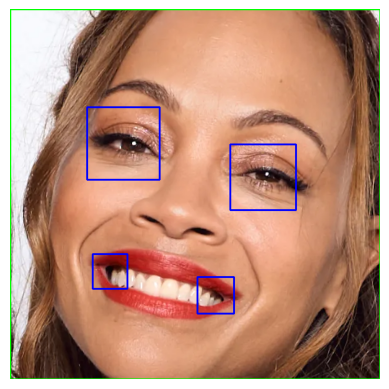

Embeddings extraits pour un visage aligné : tensor([[-7.6273e-02, -1.8105e-02, -5.8403e-02,  1.6167e-02,  8.5938e-02,
         -7.9092e-02,  8.5115e-02, -2.0876e-02, -9.0709e-02,  5.3235e-02,
          5.8940e-02,  7.4524e-03, -2.6700e-02, -6.7894e-02,  3.3258e-02,
          6.6341e-03, -4.3957e-02,  3.1744e-02,  1.0963e-02,  2.2813e-02,
         -1.2450e-02,  8.0712e-02, -1.0567e-01,  4.8160e-03, -1.1712e-03,
          1.7265e-02,  1.9980e-02, -9.5420e-02,  6.3019e-02, -2.2446e-02,
         -4.5883e-02, -5.4075e-02,  6.7052e-02,  3.0099e-02,  2.1087e-02,
         -2.7958e-02,  7.1427e-03, -4.9457e-02,  7.2411e-02,  2.3444e-02,
         -5.2886e-02, -6.3052e-02,  1.7314e-02, -5.9245e-02, -7.1544e-02,
          8.5169e-02,  2.5006e-03,  7.3637e-06,  8.1646e-02,  8.0557e-02,
          4.3545e-02,  1.2029e-02, -6.2727e-02, -3.1830e-02,  7.6469e-02,
         -9.7244e-02, -1.1665e-02,  5.6241e-03, -9.8316e-02, -1.2336e-02,
         -2.7200e-02,  7.9968e-02,  1.9297e-02, -3.1942e-02, -2.9017

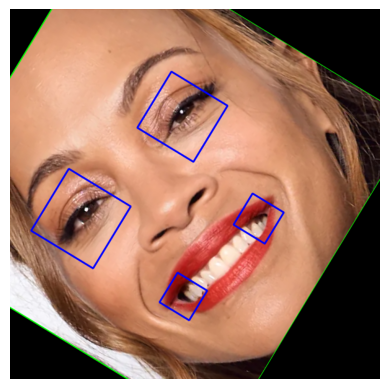

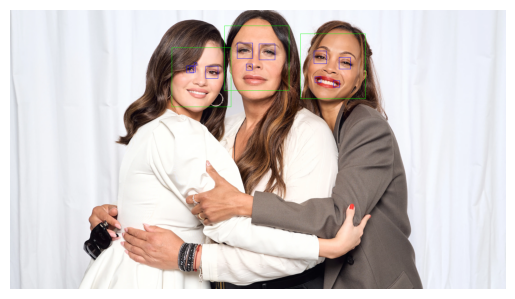

In [23]:
process_face_extraction_opencv(images2)